In [1]:
import os
from google.colab import drive

In [2]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, "'My Drive'","'Colab Notebooks'","TransE-PyTorch-Drive")

drive.mount(gdrive_dir, force_remount=False)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
!ls $data_dir

data.py      images	      metric.py       README.md		synth_data
fb15k	     maincolab.ipynb  metric_test.py  requirements.txt
fb15k-small  main.py	      model.py	      storage.py


In [4]:
print(data_dir)
data_dir_contents = data_dir + '/.'

/content/gdrive/'My Drive'/'Colab Notebooks'/TransE-PyTorch-Drive


In [5]:
!cp -r $data_dir_contents ./

In [ ]:
# !pip install -r requirements.txt

     |████████████████████████████████| 103 kB 5.3 MB/s 
     |████████████████████████████████| 17.3 MB 19.7 MB/s 
     |████████████████████████████████| 109.3 MB 51 kB/s 
     |████████████████████████████████| 773.1 MB 13 kB/s 
     |████████████████████████████████| 10.1 MB 18.3 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 3.1 MB 31.1 MB/s 
     |████████████████████████████████| 488 kB 46.4 MB/s 
  Created wheel for absl-py: filename=absl_py-0.8.1-py3-none-any.whl size=121174 sha256=5d13f07e043daeb6a455bb5da8bb984b56dc8e0290e6d5ad807e639670e1db25
  Stored in directory: /root/.cache/pip/wheels/46/91/e3/0fced4f5fbc0a051a5667096826186c9ff60f2d0e9bf0f1cdc
Successfully built absl-py
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.0.0
    Uninstalling abs

In [6]:
#from absl import app
#from absl import flags
import data
import metric
import model as model_definition
import os
import storage
import torch
import torch.optim as optim
from torch.utils import data as torch_data
from torch.utils import tensorboard
from typing import Tuple

In [7]:
lr=0.01
seed=1234
batch_size=128
validation_batch_size=64
vector_length=50
margin=1.0
norm=1
epochs=10000
dataset_path="./fb15k"
use_gpu=True
validation_freq=10
checkpoint_path=""
tensorboard_log_dir="./runs"

In [8]:
HITS_AT_1_SCORE = float
HITS_AT_3_SCORE = float
HITS_AT_10_SCORE = float
MRR_SCORE = float
METRICS = Tuple[HITS_AT_1_SCORE, HITS_AT_3_SCORE, HITS_AT_10_SCORE, MRR_SCORE]

In [8]:
# from tqdm import tqdm

In [9]:
def test(model: torch.nn.Module, data_generator: torch_data.DataLoader, entities_count: int,
         summary_writer: tensorboard.SummaryWriter, device: torch.device, epoch_id: int, metric_suffix: str,
         ) -> METRICS:
    examples_count = 0.0
    hits_at_1 = 0.0
    hits_at_3 = 0.0
    hits_at_10 = 0.0
    mrr = 0.0

    entity_ids = torch.arange(end=entities_count, device=device).unsqueeze(0)
    for head, relation, tail in data_generator:
        current_batch_size = head.size()[0]

        head, relation, tail = head.to(device), relation.to(device), tail.to(device)
        all_entities = entity_ids.repeat(current_batch_size, 1)
        heads = head.reshape(-1, 1).repeat(1, all_entities.size()[1])
        relations = relation.reshape(-1, 1).repeat(1, all_entities.size()[1])
        tails = tail.reshape(-1, 1).repeat(1, all_entities.size()[1])

        # Check all possible tails
        triplets = torch.stack((heads, relations, all_entities), dim=2).reshape(-1, 3)
        tails_predictions = model.predict(triplets).reshape(current_batch_size, -1)
        # Check all possible heads
        triplets = torch.stack((all_entities, relations, tails), dim=2).reshape(-1, 3)
        heads_predictions = model.predict(triplets).reshape(current_batch_size, -1)

        # Concat predictions
        predictions = torch.cat((tails_predictions, heads_predictions), dim=0)
        ground_truth_entity_id = torch.cat((tail.reshape(-1, 1), head.reshape(-1, 1)))

        hits_at_1 += metric.hit_at_k(predictions, ground_truth_entity_id, device=device, k=1)
        hits_at_3 += metric.hit_at_k(predictions, ground_truth_entity_id, device=device, k=3)
        hits_at_10 += metric.hit_at_k(predictions, ground_truth_entity_id, device=device, k=10)
        mrr += metric.mrr(predictions, ground_truth_entity_id)

        examples_count += predictions.size()[0]

    hits_at_1_score = hits_at_1 / examples_count * 100
    hits_at_3_score = hits_at_3 / examples_count * 100
    hits_at_10_score = hits_at_10 / examples_count * 100
    mrr_score = mrr / examples_count * 100
    # summary_writer.add_scalar('Metrics/Hits_1/' + metric_suffix, hits_at_1_score, global_step=epoch_id)
    # summary_writer.add_scalar('Metrics/Hits_3/' + metric_suffix, hits_at_3_score, global_step=epoch_id)
    # summary_writer.add_scalar('Metrics/Hits_10/' + metric_suffix, hits_at_10_score, global_step=epoch_id)
    # summary_writer.add_scalar('Metrics/MRR/' + metric_suffix, mrr_score, global_step=epoch_id)

    return hits_at_1_score, hits_at_3_score, hits_at_10_score, mrr_score

In [10]:
torch.random.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [11]:
path = dataset_path
train_path = os.path.join(path, "train.txt")
validation_path = os.path.join(path, "valid.txt")
test_path = os.path.join(path, "test.txt")


In [12]:
entity2id, relation2id = data.create_mappings(train_path)

batch_size = batch_size
vector_length = vector_length
margin = margin
norm = norm
learning_rate = lr
epochs = epochs
device = torch.device('cuda') if use_gpu else torch.device('cpu')

In [13]:
train_set = data.FB15KDataset(train_path, entity2id, relation2id)
train_generator = torch_data.DataLoader(train_set, batch_size=batch_size)
validation_set = data.FB15KDataset(validation_path, entity2id, relation2id)
validation_generator = torch_data.DataLoader(validation_set, batch_size=validation_batch_size)
test_set = data.FB15KDataset(test_path, entity2id, relation2id)
test_generator = torch_data.DataLoader(test_set, batch_size=validation_batch_size)

In [14]:
model = model_definition.TransE(entity_count=len(entity2id), relation_count=len(relation2id), dim=vector_length,
                                    margin=margin,
                                    device=device, norm=norm)  # type: torch.nn.Module
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
summary_writer = tensorboard.SummaryWriter(log_dir=tensorboard_log_dir)
start_epoch_id = 1
step = 0
best_score = 0.0

if checkpoint_path:
  start_epoch_id, step, best_score = storage.load_checkpoint(checkpoint_path, model, optimizer)

print(model)

TransE(
  (entities_emb): Embedding(14506, 50, padding_idx=14505)
  (relations_emb): Embedding(238, 50, padding_idx=237)
  (criterion): MarginRankingLoss()
)


In [16]:
# Training loop
losses = []
test_scores = []
for epoch_id in range(start_epoch_id, epochs + 1):
    print("Starting epoch: ", epoch_id)
    loss_impacting_samples_count = 0
    samples_count = 0
    model.train()

    # pbar = tqdm(train_generator)
    total_loss = 0
    # local_step = 0
    for local_heads, local_relations, local_tails in train_generator:
        # local_heads, local_relations, local_tails = batch
        local_heads, local_relations, local_tails = (local_heads.to(device), local_relations.to(device),
                                                      local_tails.to(device))

        positive_triples = torch.stack((local_heads, local_relations, local_tails), dim=1)

        # Preparing negatives.
        # Generate binary tensor to replace either head or tail. 1 means replace head, 0 means replace tail.
        head_or_tail = torch.randint(high=2, size=local_heads.size(), device=device)
        random_entities = torch.randint(high=len(entity2id), size=local_heads.size(), device=device)
        broken_heads = torch.where(head_or_tail == 1, random_entities, local_heads)
        broken_tails = torch.where(head_or_tail == 0, random_entities, local_tails)
        negative_triples = torch.stack((broken_heads, local_relations, broken_tails), dim=1)

        optimizer.zero_grad()

        loss, pd, nd = model(positive_triples, negative_triples)
        loss.mean().backward()

        # summary_writer.add_scalar('Loss/train', loss.mean().data.cpu().numpy(), global_step=step)
        # summary_writer.add_scalar('Distance/positive', pd.sum().data.cpu().numpy(), global_step=step)
        # summary_writer.add_scalar('Distance/negative', nd.sum().data.cpu().numpy(), global_step=step)

        loss = loss.data.cpu()
        loss_impacting_samples_count += loss.nonzero().size()[0]
        samples_count += loss.size()[0]

        optimizer.step()
        step += 1
        total_loss += loss.mean()
        # pbar.set_description('Avg Loss: {:>5,}'.format(total_loss / (local_step + 1)))

    losses.append(total_loss / len(train_generator))
    print('Avg Loss: {:>5,}'.format(total_loss / len(train_generator)))

    # summary_writer.add_scalar('Metrics/loss_impacting_samples', loss_impacting_samples_count / samples_count * 100,
    #                           global_step=epoch_id)

    if epoch_id % validation_freq == 0:
        model.eval()
        _, _, hits_at_10, _ = test(model=model, data_generator=validation_generator,
                                    entities_count=len(entity2id),
                                    device=device, summary_writer=summary_writer,
                                    epoch_id=epoch_id, metric_suffix="val")
        score = hits_at_10
        test_scores.append(score)
        print('Score: {:>5,}'.format(score))
        if score > best_score:
            best_score = score
            storage.save_checkpoint(model, optimizer, epoch_id, step, best_score)

Starting epoch:  1
Avg Loss: 1.0543805360794067
Starting epoch:  2
Avg Loss: 1.0105862617492676
Starting epoch:  3
Avg Loss: 0.9798903465270996
Starting epoch:  4
Avg Loss: 0.9526659846305847
Starting epoch:  5
Avg Loss: 0.9328758716583252
Starting epoch:  6
Avg Loss: 0.9120991826057434
Starting epoch:  7
Avg Loss: 0.8973413705825806
Starting epoch:  8
Avg Loss: 0.87987220287323
Starting epoch:  9
Avg Loss: 0.8632854223251343
Starting epoch:  10
Avg Loss: 0.853204607963562
Score: 5.332192757342458
Starting epoch:  11
Avg Loss: 0.8391176462173462
Starting epoch:  12
Avg Loss: 0.8265623450279236
Starting epoch:  13
Avg Loss: 0.8137883543968201
Starting epoch:  14
Avg Loss: 0.801986813545227
Starting epoch:  15
Avg Loss: 0.7888036370277405
Starting epoch:  16
Avg Loss: 0.7784390449523926
Starting epoch:  17
Avg Loss: 0.7689791917800903
Starting epoch:  18
Avg Loss: 0.7588694095611572
Starting epoch:  19
Avg Loss: 0.7458746433258057
Starting epoch:  20
Avg Loss: 0.7399624586105347
Score: 8

KeyboardInterrupt: ignored

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

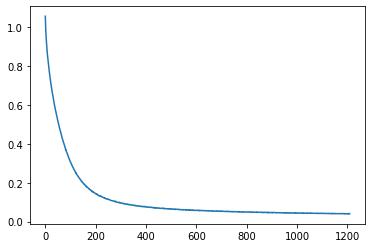

In [18]:
plt.plot(losses)

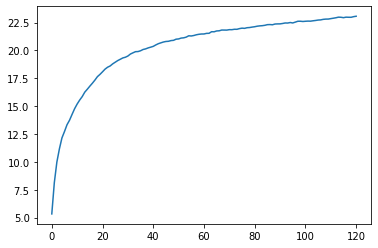

In [19]:
plt.plot(test_scores)

In [20]:
# Testing the best checkpoint on test dataset
storage.load_checkpoint("checkpoint.tar", model, optimizer)
best_model = model.to(device)
best_model.eval()
scores = test(model=best_model, data_generator=test_generator, entities_count=len(entity2id), device=device,
              summary_writer=summary_writer, epoch_id=1, metric_suffix="test")
print("Test scores: ", scores)

Test scores:  (7.583308902570117, 13.495553601094498, 22.798788234144435, 12.778492546100182)
